In [253]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

In [2]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt

import cx_rate
import trials
import plotter


from cx_spiking.constants import *

import cx_spiking.plotting
import cx_spiking.inputs
import cx_spiking.network_creation as nc

import cx_spiking.optimisation.metric as metric

In [3]:
######################################
### INPUTS
######################################
route_file = os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/data/route.npz')
T_outbound = 1500
T_inbound = 1500

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=True)

# Convert headings
headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)
headings = np.concatenate((headings, np.zeros(headings.shape)), axis=0)


# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)
flow = np.concatenate((flow, np.zeros(flow.shape)), axis=0)

######################################
### RATE BASED CX
######################################
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                               T_outbound=T_outbound,
                                               T_inbound=0,
                                               noise=noise,
                                               cx=cx,
                                               route=(h[:T_outbound], v[:T_outbound]))

Load route from /Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz
/Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz exists - not overwriting it


# Extract heading during route

In [254]:
######################################
### SPIKE BASED CX
######################################
start_scope()

time_step = 20 # ms

In [255]:
h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')
SPM_H = SpikeMonitor(P_HEADING)

f_stimulus = TimedArray(flow*Hz, dt=1.*time_step*ms)
P_FLOW = PoissonGroup(N_TN2, rates='f_stimulus(t,i)')
SPM_FLOW = SpikeMonitor(P_FLOW)

In [256]:
# Neuron groups already optimised
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, TL2_neuron_params, name='TL2_source_network')
G_CL1 = nc.generate_neuron_groups(N_CL1, eqs, threshold_eqs, reset_eqs, CL1_neuron_params, name='CL1_source_network')
G_TB1 = nc.generate_neuron_groups(N_TB1, eqs, threshold_eqs, reset_eqs, TB1_neuron_params, name='TB1_source_network')
G_TN2 = nc.generate_neuron_groups(N_TN2, eqs, threshold_eqs, reset_eqs, TN2_neuron_params, name='TN2_source_network')

# Synapses optimised
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, model=synapses_model, 
                                      params=H_TL2_synapses_params, on_pre=synapses_eqs_ex)
S_TL2_CL1 = nc.connect_synapses(G_TL2, G_CL1, W_TL2_CL1, model=synapses_model, 
                                params=TL2_CL1_synapses_params, on_pre=synapses_eqs_ex)
S_CL1_TB1 = nc.connect_synapses(G_CL1, G_TB1, W_CL1_TB1, model=synapses_model, 
                                params=CL1_TB1_synapses_params, on_pre=synapses_eqs_ex)
S_TB1_TB1 = nc.connect_synapses(G_TB1, G_TB1, W_TB1_TB1, model=synapses_model, 
                                params=TB1_TB1_synapses_params, on_pre=synapses_eqs_in)
S_P_FLOW_TN2 = nc.connect_synapses(P_FLOW, G_TN2, W_FLOW_TN2, model=synapses_model, 
                                   params=F_TN2_synapses_params, on_pre=synapses_eqs_ex)

SPM_TB1 = SpikeMonitor(G_TB1)
SPM_TN2 = SpikeMonitor(G_TN2)

In [257]:
global heading_angles, velocities
heading_angles = np.zeros(T_outbound)
velocities = np.zeros((T_outbound, 2))

def extract_spike_counts(SPM, t, time_step):
    spike_trains = SPM.spike_trains()
    neurons = np.zeros(len(SPM.spike_trains()))
    for idx in range(len(spike_trains)):
        spike_train = spike_trains[idx]
        neurons[idx] = len(spike_train[(spike_train > t-time_step*ms) & (spike_train < t)])
    return neurons

@network_operation(dt=time_step*ms)
def extract_heading(t):
    global heading_angles

    timestep = int((t/ms) / time_step)
    
    if t < time_step*ms:
        heading_angles[timestep] = 4 # range is [0,8] to represent [-pi,pi]
        return
    neurons = extract_spike_counts(SPM_TB1, t, time_step)    
    
    if np.sum(neurons) > 0:
        #angle = np.ma.average(np.arange(N_TB1), weights=neurons)## - int(N_TB1//2)
        #print(neurons, angle)
        # angle = (angle - 0) / (N_TB1 - 0) * (np.pi - (-np.pi))
        #heading_angles[timestep] = angle
        angle = np.argmax(neurons)
        angle = (angle - 0) / (N_TB1 - 0) * (np.pi - (-np.pi)) - np.pi
        heading_angles[timestep] = angle
    else:
        heading_angles[timestep] = heading_angles[timestep-1]
    #print(neurons, mean, std, np.ma.average(np.arange(N_TB1), weights=neurons))
    #print()
    
@network_operation(dt=time_step*ms)
def extract_velocity(t):
    global velocities
    
    timestep = int((t/ms) / time_step)
    if t < time_step*ms:
        velocities[timestep] = [0,0]
        return
    neurons_responses = extract_spike_counts(SPM_TN2, t, time_step)

    velocities[timestep] = neurons_responses

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/ff/.pyenv/versions/3.8.2/lib/python3.8/tkinter/__init__.py", line 1883, in __call__
    return self.func(*args)
  File "/Users/ff/.pyenv/versions/3.8.2/lib/python3.8/tkinter/__init__.py", line 804, in callit
    func(*args)
  File "/Users/ff/.pyenv/versions/3.8.2/envs/py_msc/lib/python3.8/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/Users/ff/.pyenv/versions/3.8.2/envs/py_msc/lib/python3.8/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/Users/ff/.pyenv/versions/3.8.2/envs/py_msc/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/Users/ff/.pyenv/versions/3.8.2/envs/py_msc/lib/python3.8/site-packages/matplotlib/backend_bases.py", line 1535, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backe

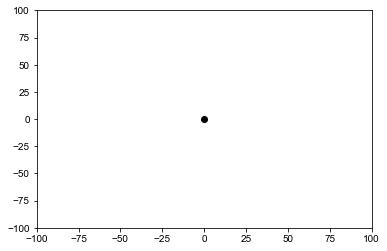

In [258]:
global bee_plot, bee_x, bee_y, ref_angles

bee_x = 0
bee_y = 0

ref_angles = np.linspace(-np.pi, 0+np.pi, N_TB1, endpoint=False)

f = plt.figure(1)
axis([-100,100,-100,100])

bee_plot = plot(bee_x, bee_y, 'ko') # Vehicle

@network_operation(dt=time_step*ms)
def plot_bee(t):
    global bee_plot, bee_x, bee_y, ref_angles, heading_angles, velocities 
    
    if t < time_step*ms:
        return

    timestep = int((t/ms) / time_step)
    
    angle = heading_angles[timestep]
    x_comp = np.cos(angle)
    y_comp = np.sin(angle)
    bee_x += x_comp
    bee_y += y_comp
    print(angle, x_comp, y_comp, bee_x, bee_y)
    bee_plot = plot(bee_x, bee_y, 'ko')    

    axis([-100,100,-100,100])
    draw()
    pause(0.01)



In [259]:
run((50)*time_step*ms, report='text')

Exception ignored in: <bound method InstanceTrackerSet.remove of InstanceTrackerSet({<weakref at 0x133f91860; dead>, <weakref at 0x133f66770; dead>, <weakref at 0x12f470f40; dead>, <weakref at 0x1301b8900; to 'Resetter' at 0x12f41c310>, <weakref at 0x12f912e00; to 'Synapses' at 0x12f41c370>, <weakref at 0x12f61ab30; to 'SpikeMonitor' at 0x12f4843a0>, <weakref at 0x133500f40; to 'StateUpdater' at 0x12f41c400>, <weakref at 0x12f470cc0; dead>, <weakref at 0x1350c9220; to 'PoissonGroup' at 0x1243cc490>, <weakref at 0x130359270; to 'Resetter' at 0x12f41c490>, <weakref at 0x12f473c70; to 'Synapses' at 0x12f484520>, <weakref at 0x12f576f40; to 'CythonCodeObject' at 0x12f564550>, <weakref at 0x130359400; to 'Synapses' at 0x12f41c610>, <weakref at 0x134dbe900; to 'CythonCodeObject' at 0x12cd806a0>, <weakref at 0x1361ccbd0; to 'Thresholder' at 0x1361d06d0>, <weakref at 0x134e75c20; to 'StateUpdater' at 0x12f41c730>, <weakref at 0x13634a090; to 'Resetter' at 0x136338730>, <weakref at 0x12fd2e8b0;

KeyboardInterrupt: 

# Experiments with velocities decoding

WARNING    /Users/ff/dev/MSc/CX_Path_Integration/cx_spiking/inputs.py:33: RuntimeWarning: invalid value encountered in true_divide
  d = ((d - d.min()) * (vmax - vmin)) / (d.max() - d.min()) + vmin
 [py.warnings]
  d = ((d - d.min()) * (vmax - vmin)) / (d.max() - d.min()) + vmin

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/ff/.pyenv/versions/3.8.2/lib/python3.8/tkinter/__init__.py", line 1883, in __call__
    return self.func(*args)
  File "/Users/ff/.pyenv/versions/3.8.2/lib/python3.8/tkinter/__init__.py", line 804, in callit
    func(*args)
  File "/Users/ff/.pyenv/versions/3.8.2/envs/py_msc/lib/python3.8/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/Users/ff/.pyenv/versions/3.8.2/envs/py_msc/lib/python3.8/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/Users/ff/.pyenv/versions/3.8.2/envs/py_msc/lib/python3.8/site-packages/ma

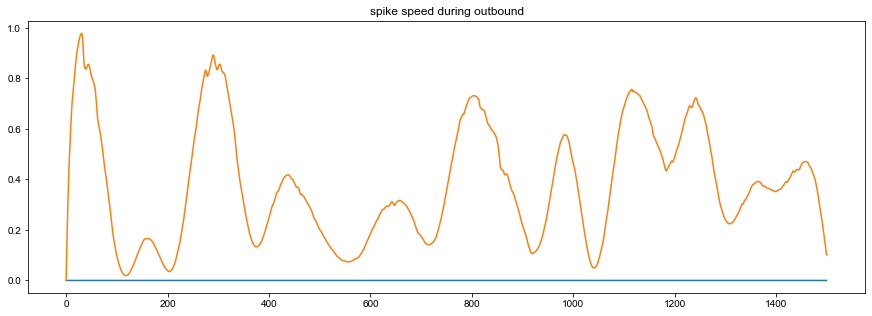

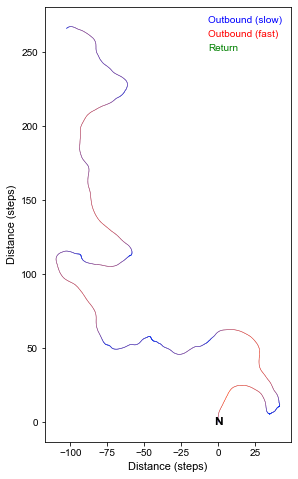

In [261]:
norm_velocities = cx_spiking.inputs.normalise_range(velocities, vmin=0, vmax=1)

def get_speed(v):
    xy = np.vstack([np.array([0.0, 0.0]), np.cumsum(v, axis=0)])
    x, y = xy[:, 0], xy[:, 1]

    speed = np.clip(np.linalg.norm(np.vstack([np.diff(x), np.diff(y)]), axis=0), 0, 1)
    return speed

speed = get_speed(velocities)

plt.figure(figsize=(15,5))
plt.plot(speed, label='tn2 speed')
plt.plot(get_speed(v), label='real speed')
plt.title('spike speed during outbound')
plt.show()

plotter.plot_route(h, v, T_outbound=T_outbound, T_inbound=0, plot_speed=True,figsize=(5,8))
plt.show()

# Experiments with heading decoding

7.0


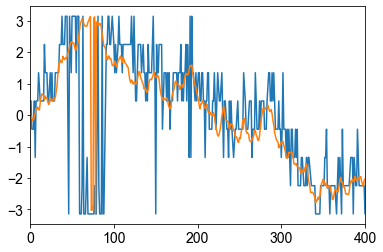

In [198]:
def to_degrees(data):
    print(data.max())
    new_value = (data - 0) / (data.max() - 0) * (np.pi - (-np.pi)) - np.pi
    return new_value

def fill_nans(data):
    nans, x= np.isnan(data), lambda z: z.nonzero()[0]
    data[nans]= np.interp(x(nans), x(~nans), data[~nans])
    return data

heads = fill_nans(to_degrees(heading_angles))
plt.plot(heads)
plt.plot(h)
plt.xlim([0,400])
plt.show()

7.0


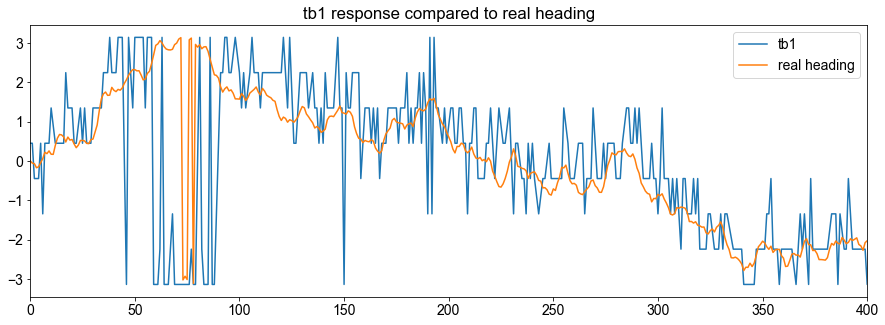

0.0 7.0


In [200]:
plt.figure(figsize=(15,5))
#plt.plot(heading_angles, label='tb1')
plt.plot(fill_nans(to_degrees(heading_angles)), label='tb1')
plt.plot(h, label='real heading')
plt.xlim([0,400])
plt.title('tb1 response compared to real heading')
plt.legend()
plt.show()

print(heading_angles.min(), heading_angles.max())

In [196]:
print(heading_angles.min(), heading_angles.max())
print(to_degrees(heading_angles).min(), to_degrees(heading_angles).max())

0.0 7.0
7.0
7.0
-3.141592653589793 3.141592653589793


In [205]:
print(np.linspace(-np.pi, 0+np.pi, N_TB1, endpoint=False))

[-3.14159265 -2.35619449 -1.57079633 -0.78539816  0.          0.78539816
  1.57079633  2.35619449]


In [260]:
import scipy

def circular_mean(weights, angles):
    x = y = 0.
    for angle, weight in zip(angles, weights):
        x += math.cos(math.radians(angle)) * weight
        y += math.sin(math.radians(angle)) * weight
    mean = math.degrees(math.atan2(y, x))
    return mean

def vonmises_fit(weights, sigma=0.8):
    kappa = 1./sigma**2
    vm = scipy.stats.vonmises.fit(weights, fscale=kappa)
    return vm

angles = np.linspace(-np.pi, 0+np.pi, N_TB1, endpoint=False)

print(angles, np.rad2deg(angles))
print()

weights=[0., 0., 0., 0., 0., 4., 6., 5.]
#print(vonmises_fit(weights))
print(circular_mean(weights, angles), np.rad2deg(circular_mean(weights, angles)))
print()
weights = [1., 0., 0., 0., 0., 0., 2., 2.]
#weights = np.roll(weights, -4)
print(vonmises_fit(weights))
print(circular_mean(weights, angles), np.rad2deg(circular_mean(weights, angles)))
print()

weights = [0., 0., 0., 0., 1., 0., 0., 0.]
print(vonmises_fit(weights))
print(circular_mean(weights, angles), np.rad2deg(circular_mean(weights, angles)))





#print(angles)

#print(circular_mean(weights, angles))

[-3.14159265 -2.35619449 -1.57079633 -0.78539816  0.          0.78539816
  1.57079633  2.35619449] [-180. -135.  -90.  -45.    0.   45.   90.  135.]

1.6231575016338562 93.00007432861898

(3.829404964474624, 0.5867065491242953, 1.5624999999999998)
0.9431073102454032 54.03606850499675

(23.10510469265304, 0.11936470624046147, 1.5624999999999998)
0.0 0.0


In [96]:
######################################
### SPIKE BASED CX
######################################
start_scope()

time_step = 20 # ms

In [97]:
motors = cx_spiking.inputs.compute_motors(cx_log.cpu1)
m2 = cx_spiking.inputs.normalise_range(motors)

h_motors = TimedArray(m2.T*Hz, dt=1.*time_step*ms)
P_MOTOR = PoissonGroup(N_MOTOR, rates='h_motors(t,i)')
SPM_MOTOR = SpikeMonitor(P_MOTOR)

In [98]:
run((T_outbound+T_inbound)*time_step*ms, report='text')

Starting simulation at t=0. s for a duration of 60. s
31.3714 s (52%) simulated in 10s, estimated 9s remaining.
60. s (100%) simulated in 18s


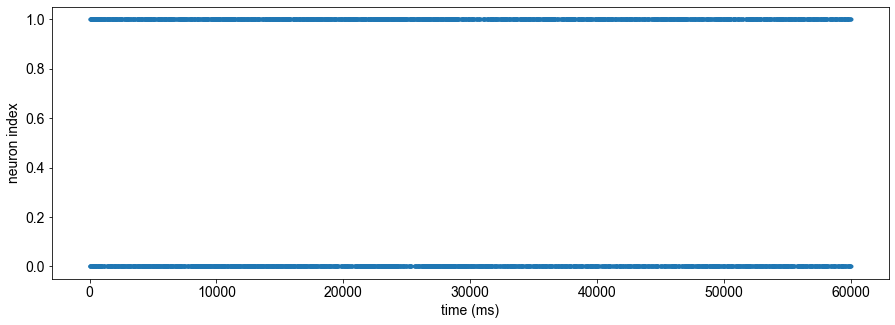

In [99]:
plt.figure(figsize=(15,5))
brian_plot(SPM_MOTOR)

In [100]:
motor_rates = cx_spiking.inputs.get_spikes_rates(SPM_MOTOR, N_MOTOR, T_outbound+T_inbound, time_step)

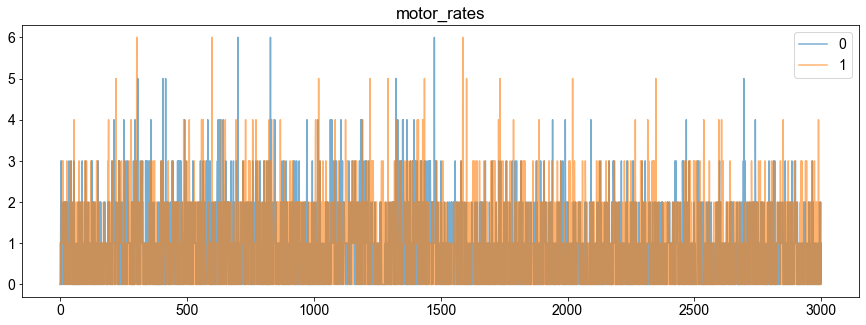

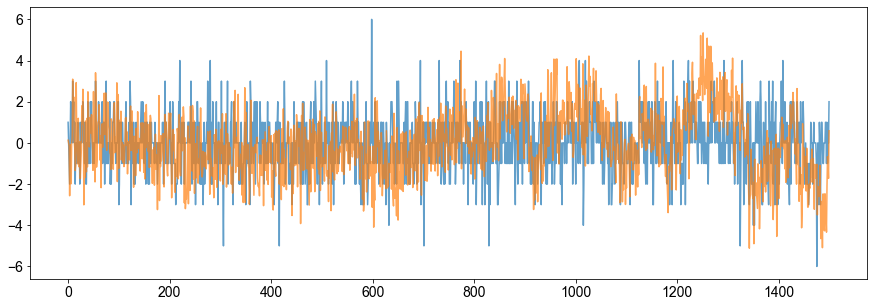

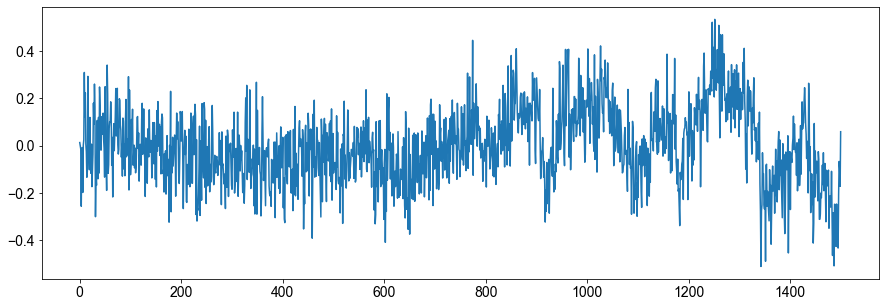

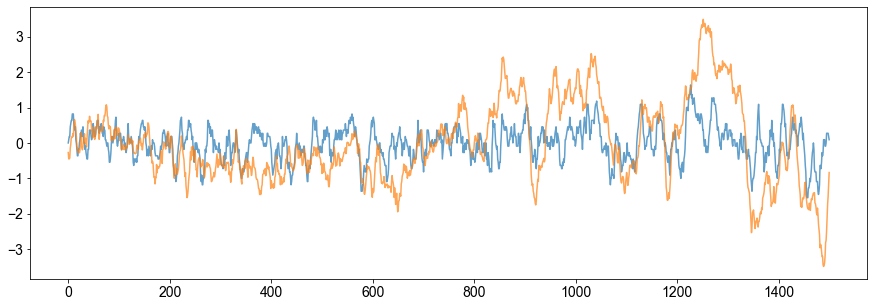

In [113]:
plt.figure(figsize=(15,5))
plt.title('motor_rates')
for idx, r in enumerate(motor_rates):
    plt.plot(r, alpha=0.6, label=idx)
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(motor_rates[1, :T_outbound] - motor_rates[0, :T_outbound], alpha=0.7, label='spiking')
plt.plot(cx_log.motor*10, alpha=0.7, label='rate')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(cx_log.motor)
plt.show()

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.figure(figsize=(15,5))
plt.plot(smooth(motor_rates[1, :T_outbound] - motor_rates[0, :T_outbound], 11), alpha=0.7, label='spiking')
plt.plot(smooth(cx_log.motor*10, 11), alpha=0.7, label='rate')
plt.show()



[5.35000e+01 6.60000e+01 6.91000e+01 ... 5.99510e+04 5.99542e+04
 5.99805e+04]


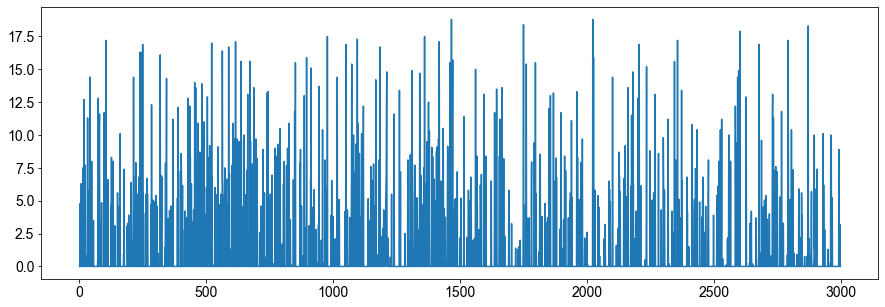

[1.77000e+01 6.93000e+01 1.11100e+02 ... 5.99403e+04 5.99555e+04
 5.99847e+04]


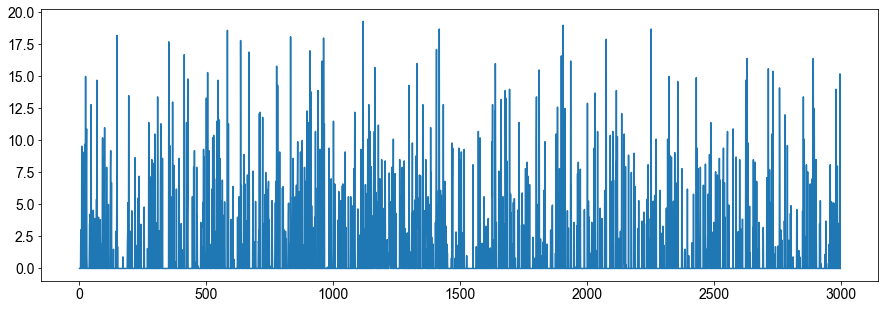

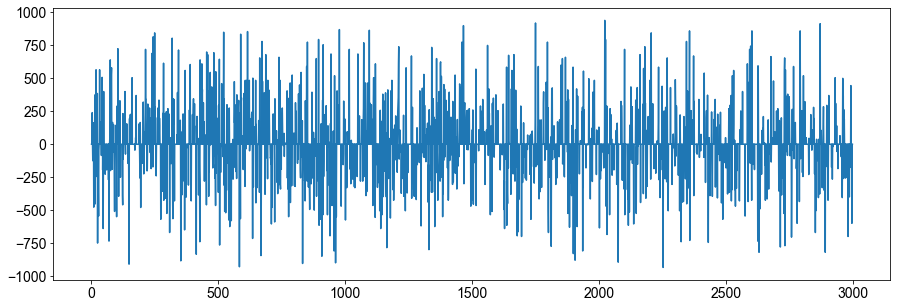

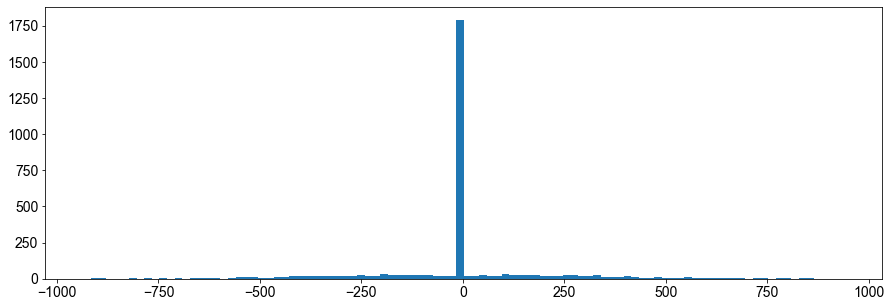

In [141]:
# compute ISI of each time_step window
spikes_t = SPM_MOTOR.t/ms
spikes_i = SPM_MOTOR.i

spikes_out = np.zeros((N_MOTOR, T_outbound+T_inbound))
bins = np.arange(0, (T_outbound+T_inbound+1)*time_step, time_step)

isi = np.zeros((N_MOTOR, T_outbound+T_inbound))
for i in range(N_MOTOR):
    spikes = spikes_t[spikes_i == i]
    print(spikes)
    for ts in range(T_outbound+T_inbound):
        idxs = np.where(np.logical_and(spikes > ts*time_step, spikes<= (ts+1)*time_step))
        spikes_to_consider = spikes[idxs]
        if len(spikes_to_consider) > 1:
            diffs = np.diff(spikes_to_consider)
            #print(ts, spikes_to_consider, diffs, np.mean(diffs))
        #spikes_count, _ = np.histogram(spikes, bins=bins)
        #spikes_out[i,:] = spikes_count
            isi[i, ts] = np.mean(diffs)
    plt.figure(figsize=(15,5))
    plt.plot(isi[i])
    plt.show()
    
plt.figure(figsize=(15,5))
plt.plot((isi[0]-isi[1])* 1000/time_step) 
plt.show()

plt.figure(figsize=(15,5))
plt.hist((isi[0]-isi[1])* 1000/time_step, bins=100)
plt.show()

# OLD STUFF

In [77]:
######################################
### SPIKE BASED CX
######################################
start_scope()

time_step = 20 # ms

In [78]:
h_stimulus = TimedArray(headings*Hz, dt=1.*time_step*ms)
P_HEADING = PoissonGroup(N_TL2, rates='h_stimulus(t,i)')
SPM_H = SpikeMonitor(P_HEADING)

In [79]:
run((T_outbound+T_inbound)*time_step*ms, report='text')

Starting simulation at t=0. s for a duration of 60. s
33.4522 s (55%) simulated in 10s, estimated 8s remaining.
58.7787 s (97%) simulated in 20s, estimated < 1s remaining.
60. s (100%) simulated in 20s


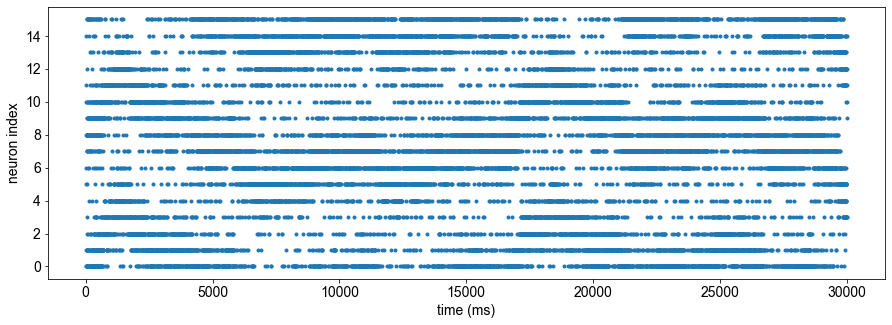

In [80]:
plt.figure(figsize=(15,5))
brian_plot(SPM_H)